# Visualizing token embeddings and grid search
This notebook shows us basic functionality of prospectors -- both with layer (I) quantization and layer (II) convolution. Through this notebook, we also visualize any intermediaries

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
mapping_path = None
embed_type = "multidict"
embed_dict_path = "/dfs/scratch1/gmachi/datasets/wikisection_processed/embed_dict.obj"

In [10]:
from k2 import K2Processor

In [11]:
proc_args = {"datatype":"text",
        "k":20,
        "quantizer_type": "kmeans",
        "embeddings_path": embed_dict_path,
        "embeddings_type": embed_type,
        "mapping_path": None,
        "sample_size": 5000,
        "sample_scheme": "random",
        "dataset_path": None,
        "verbosity": "full",
        "so_dict_path": "/dfs/scratch1/gmachi/datasets/wikisection_processed/train-sos.obj",
        "mapping_path": "/dfs/scratch1/gmachi/datasets/wikisection_processed/train-doc-labs.obj"}
proc = K2Processor(proc_args)


Embeddings path provided, loading embeddings...


In [12]:
proc.fit_quantizer()

Chosen KMeans model for quantization...
sampled 191 known salient objects!
total embeds: 5000
collapsing from dim 384 --> 2


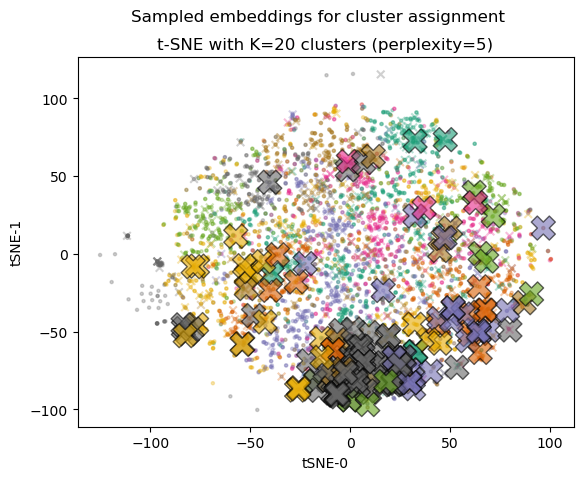

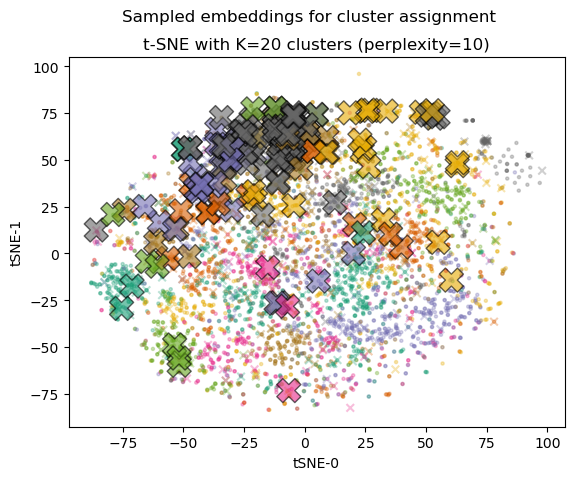

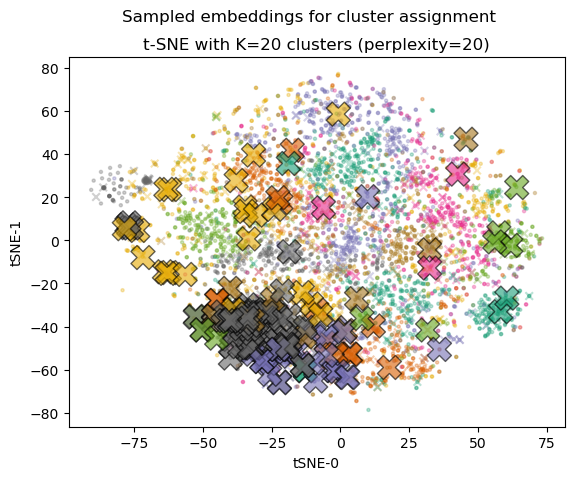

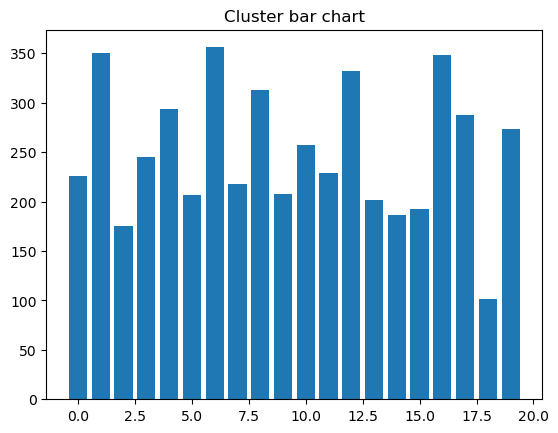

In [13]:
proc.visualize_quantizer()

# Sprite construction

In [14]:
G_dir = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train_Gs"

In [15]:
import utils
import matplotlib.pyplot as plt
import numpy as np

[7, 19, 4, 13, 4, 4, 7, 7, 16, 4, 4, 4, 7, 13, 4]
colors (min, max): 4 19


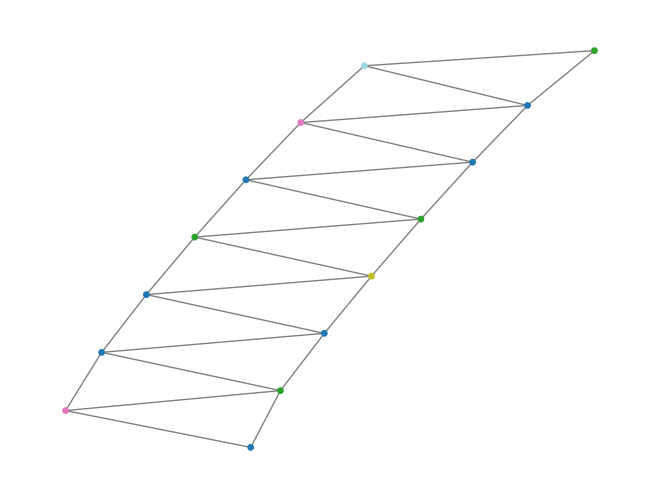

In [16]:
G_id = "doc_2498_graph.obj"
G_path = G_dir + "/" + G_id
G = utils.deserialize(G_path)

sprite = utils.construct_sprite(G, proc)
utils.visualize_sprite(sprite, modality="graph")

In [17]:
labs = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train-doc-labs.obj"
lab_dict = utils.deserialize(labs)
lab_dict[2498]

0

In [18]:
from k2 import K2Model

In [19]:
label_dict = utils.deserialize("/dfs/scratch1/gmachi/datasets/wikisection_processed/train-doc-labs.obj")
hparams = {"alpha": 0.01, "tau": 1, "lambda": 0.5}
model_args = {"modality":"text",
        "processor":proc,
        "r":1,
        "variant": "inferential",
        "hparams": hparams,
        "train_graph_path": G_dir,
        "train_label_dict": label_dict}

In [20]:
k2m = K2Model(model_args)

In [21]:
k2m.create_train_array()

In [22]:
k2m.fit_kernel()

Differential Expression with alpha,tau: 0.01,1


<BarContainer object of 230 artists>

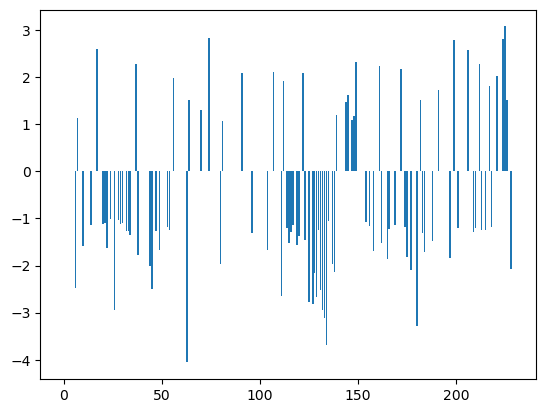

In [23]:
plt.bar(x=range(len(k2m.B)), height=list(k2m.B))

In [24]:
import os
to_viz = "doc_1107_graph.obj" # doc_2498_class_0_graph.obj
print(lab_dict[1107])
G_file = os.path.join(G_dir, to_viz)
G = utils.deserialize(G_file)
P = k2m.prospect(G)
print(P)

0
Graph with 59 nodes and 115 edges


Displaying motif graph with log10 scaling


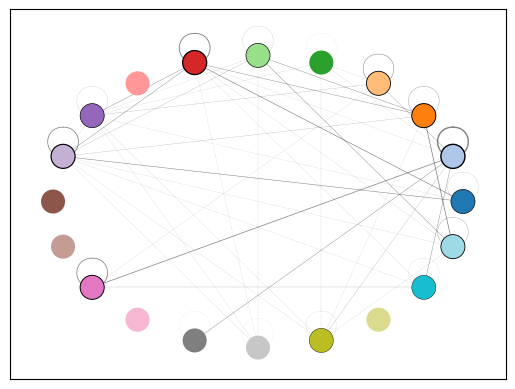

In [25]:
k2m.visualize_motif_graph(G)

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


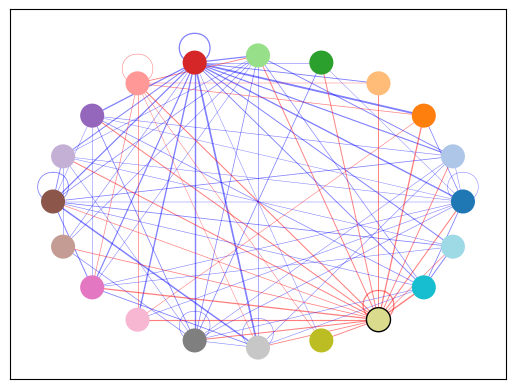

In [26]:
k2m.visualize_motif_graph()

[-1.1744921894345306, 0.0, -1.1744921894345306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.135451684059766, -8.116131924350752, -16.974604831721418, -17.648287019981755, -16.525923663387363, -9.467309533415726, -10.955296476232379, -16.692119480400883, -16.652492396648245, -11.03494146137395, -17.15877016737014, -3.272974104291953, -8.116131924350752, -2.1534212026949686, -17.954008396016448, -6.326778052364287, -2.8091338723201043, -3.77271558741125, -2.3158960773146253, -2.3158960773146253, -5.586492349421947, -3.272974104291953, -3.272974104291953, -14.017793767292432, -1.9680218163571683, -2.5008559371939816, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.1820757734152465, -1.1820757734152465, -7.156427368256779, -1.1820757734152465, -1.1820757734152465, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
colors (min, max): -17 0


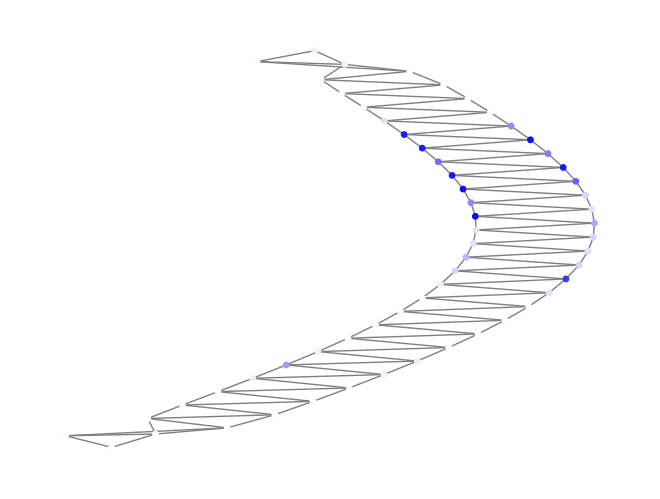

In [27]:
k2m.visualize_prospect_graph(P)

# Gridsearch

In [28]:
# # hyperparameter sweep
ks = [10,15,20,25,30]
rs = [0,1,2,4,8]
alphas = [0.01, 0.025, 0.05, 1e10]
taus = [0,1,2]
lambdas = [0.5] # keep as elastic
modelstr="minilm"

embed_type = "multidict"
embed_dict_path = "/dfs/scratch1/gmachi/datasets/wikisection_processed/embed_dict.obj"
proc_args = {"datatype":"text",
        "k":20,
        "quantizer_type": "kmeans",
        "embeddings_path": embed_dict_path,
        "embeddings_type": embed_type,
        "mapping_path": None,
        "sample_size": 5000,
        "sample_scheme": "random",
        "dataset_path": None,
        "verbosity": "full",
        "so_dict_path": "/dfs/scratch1/gmachi/datasets/wikisection_processed/train-sos.obj",
        "mapping_path": "/dfs/scratch1/gmachi/datasets/wikisection_processed/train-doc-labs.obj"}

label_dict = utils.deserialize("/dfs/scratch1/gmachi/datasets/wikisection_processed/train-doc-labs.obj")
hparams = {"alpha": 0.01, "tau": 1, "lambda": 0.5}
model_args = {"modality":"text",
        "processor":proc,
        "r":1,
        "variant": "inferential",
        "hparams": hparams,
        "train_graph_path": G_dir,
        "train_label_dict": label_dict}

In [29]:
sweep_dict = {"k": ks, "r": rs, "alpha": alphas, "tau": taus, "lambda": lambdas}
save_dir = "/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/minilm_gridsearch"

In [30]:
from evaluation import gridsearch_iteration, train_gridsearch
gt_dir = "/dfs/scratch1/gmachi/datasets/wikisection_processed/train_gts"

In [31]:
train_gridsearch(sweep_dict, save_dir, modelstr, gt_dir, proc_args, model_args)

Previous results found at: /dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/minilm_gridsearch/minilm-results_dict.obj
We have 325 models to train...
...and have 267 models trained so far!
Found fitted processor for k=10, cutoff=nan
Gridsearch: currently on ElasticNet model with k=10, r=0, cutoff=nan, lam=0.500000
Found fitted model for k10_r0_alphanan_taunan_lam0.50.model
Gridsearch: currently on hypothesis test with k=10, r=0, cutoffnan, alpha=0.010000, tau=0.000000
Found fitted model for k10_r0_alpha0.010_tau0.00_lamnan.model
Gridsearch: currently on hypothesis test with k=10, r=0, cutoffnan, alpha=0.010000, tau=1.000000
Found fitted model for k10_r0_alpha0.010_tau1.00_lamnan.model
Gridsearch: currently on hypothesis test with k=10, r=0, cutoffnan, alpha=0.010000, tau=2.000000
Found fitted model for k10_r0_alpha0.010_tau2.00_lamnan.model
Gridsearch: currently on hypothesis test with k=10, r=0, cutoffnan, alpha=0.025000, tau=0.000000
Found fitted model for k10_r0_alpha0.025_tau0.00_